In [27]:
from IPython.display import display, Image, HTML
from ipywidgets import Button, Output
import os

path = "Si_nano_muestra_3/"
extetion = ".png"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

# List of image file names
image_files = files

# Current image index
current_image_index = 0

# Output widget to display the image
out = Output()

# Function to update and display the current image
def display_image():
    with out:
        # Clear the output area
        out.clear_output()
        # Get the current image file name
        image_file = image_files[current_image_index]
        # Display the image
        display(Image(retina=False,filename=image_file, metadata={'Title': 'Hello'}))
        # Add the file name to the image
        file_name = os.path.basename(image_file)
        # Display the text next to the image
        text = "<b>" + file_name + "</b>"
        #display(HTML("<div style='float: center; font-size: 50px;'><center><br>" + text + "<br>" + text + "<br>" + text + "</center></div>"))

# Button click event handlers
def previous_image(btn):
    global current_image_index
    current_image_index = (current_image_index - 1) % len(image_files)
    display_image()

def next_image(btn):
    global current_image_index
    current_image_index = (current_image_index + 1) % len(image_files)
    display_image()

# Create buttons
previous_button = Button(description='Previous')
previous_button.on_click(previous_image)

next_button = Button(description='Next')
next_button.on_click(next_image)

# Display buttons and output widget
display(previous_button, next_button)
display(out)

# Display initial image
display_image()

Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [1]:
import os

path = "../raman_2"
extetion = ".txt"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

files

['../raman_2/Si_nano_muestra 3_25.txt',
 '../raman_2/Si_nano_muestra 3_16.txt',
 '../raman_2/Si_nano_muestra 3_63.txt',
 '../raman_2/Si_nano_muestra 3_01.txt',
 '../raman_2/Si_nano_muestra 3_64.txt',
 '../raman_2/Si_nano_muestra 3_31.txt',
 '../raman_2/Si_nano_muestra 3_46.txt',
 '../raman_2/Si_nano_muestra 3_59.txt',
 '../raman_2/Si_nano_muestra 3_57.txt',
 '../raman_2/Si_nano_muestra 3_38.txt',
 '../raman_2/Si_nano_muestra 3_62.txt',
 '../raman_2/Si_nano_muestra 3_48.txt',
 '../raman_2/Si_nano_muestra 3_37.txt',
 '../raman_2/Si_nano_muestra 3_34.txt',
 '../raman_2/Si_nano_muestra 3_33.txt',
 '../raman_2/Si_nano_muestra 3_17.txt',
 '../raman_2/Si_nano_muestra 3_65.txt',
 '../raman_2/Si_nano_muestra 3_52.txt',
 '../raman_2/Si_nano_muestra 3_32.txt',
 '../raman_2/Si_nano_muestra 3_60.txt']

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt



class RamanSpectrum:
    """
    A Class to perform ploting, cutting spectrums in a certain range
    denoise, baseline and multipeak fit. It needs the path of a 
    RamanSpectrum of type txt. It should be noted that the format of this txt 
    may be different for an observation made in another device. But in general the main
    part is inside the x,y pairs so the read of another type of format can be modified to
    provide x, and yas an np array in the initialization method.
    """

    def __init__(self, filepath, x=None,y=None):
        # Read in the data from the file or reading the x, y values

        with open(filepath, 'r', encoding='iso-8859-1') as f:
            lines = f.readlines()
        
        # Extract the metadata from the file
        self.metadata = {}
        # Creating an empty dictionary to store the coordinates
        self.dictcoords = {}

        for line in lines:
            if line.startswith("#"):
                # Storing the metadata
                key, value = line.strip().split("=")
                self.metadata[key[1:]] = value.replace('\t', '')
        
        # Now that we have the metadata stored in a dictionary, we can
        # store the value of the keys in a set of strings

        self.metakeys = self.metadata.keys()
        
        # Extract the x and y data from the file
        
        self.data = np.loadtxt(lines[len(self.metadata):])
        self.x = self.data[:,0]
        self.y = self.data[:,1]

        self.sample = self.metadata['Title'].replace(' ', '_')

        # Creating a folder to store the data
        if not os.path.exists(self.sample):
            os.makedirs(self.sample)
        
        # Saving the data as an dictionary
        for e in self.data:
            self.dictcoords[e[0]] = e[1]
    
    def plot(self):
        """Plotting the data"""
        plt.plot(self.x, self.y)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.show()

    def acces_value(self, pattern):
        matched_keys = set()
        regex = re.compile(pattern, re.IGNORECASE)
        for key in self.metakeys:
            if regex.search(key):
                matched_keys.add(key)
        return (matched_keys, [self.metadata[key] for key in matched_keys])
    
    def crop(self, lower, upper, show = False):
        """
        This method crops the x and y values to only a subset of the 
        original points. It also plots the cropped data if the show
        parameter is set to True. Always saves the cropped data as an
        image.
        """
        self.croppedx = []
        self.croppedy = []
        for e in self.x:
            if e > lower and e < upper:
                self.croppedx.append(e)
                self.croppedy.append(self.dictcoords[e])
        plt.plot(self.croppedx, self.croppedy)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title(self.metadata['Date'])
        # Saving the cropped data as an image

        if not os.path.exists(self.sample+'/cropped'):
            os.makedirs(self.sample+'/cropped')

        name = self.sample+"/cropped/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()
    
    def polifit(self, a,b,ord = 3):
        """
        a is the lowest value of the x pairs and b
        is the highest value. ord is the order of the polynomial
        to be fitted
        """
        
        x = []
        y = []
        for x_i, y_i in zip(self.croppedx,self.croppedy):
            if x_i < a or x_i > b:
                x.append(x_i)
                y.append(y_i)
        # Fitting the data
        fitted = np.polyfit(x, y, ord)

        # Plotting the first part
        plt.subplot(2, 1, 1)  # Create subplot 1
        plt.plot(self.croppedx, self.croppedy)
        plt.plot(self.croppedx, np.polyval(fitted, self.croppedx))
        plt.xlim(min(self.croppedx), max(self.croppedx))
        ef = abs(max(self.croppedy) - min(self.croppedy))/20
        plt.ylim(min(self.croppedy)-ef, max(self.croppedy)+ef)
        # Plotting the second part
        plt.subplot(2, 1, 2)  # Create subplot 2
        plt.plot(self.croppedx, self.croppedy - np.polyval(fitted, self.croppedx))
        self.polylx = self.croppedx
        self.polyly = self.croppedy - np.polyval(fitted, self.croppedx)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title(self.metadata['Date'])

        # Saving both plots in the same file
        if not os.path.exists(self.sample+'/polyfit'):
            os.makedirs(self.sample+'/polyfit')
        plt.savefig(self.sample+"/polyfit/{i}.png".format(i=self.metadata['Date']))
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    def sav_gol(self, window, order, x_arr,y_arr, show=False):
        """
        Takes the x and y values and applies a Savitzky-Golay filter
        sets self.denoisedx and self.denoisedy to the denoised values
        """
        self.denoisedx = []
        self.denoisedy = []    
        self.savgol = savgol_filter(y_arr, window, order)
        self.denoisedx = x_arr
        self.denoisedy = self.savgol
        plt.plot(self.denoisedx, self.denoisedy)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title(self.metadata['Date'] + 'Denoised')

        if not os.path.exists(self.sample+'/denoised'):
            os.makedirs(self.sample+'/denoised')

        # Saving the cropped data as an image
        name = self.sample + "/denoised/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()

    def baseline(self,degree = 1, show = False, before=False):
        # Fit polynomial baseline

        xfit = self.denoisedx[:5] + self.denoisedx[-5:]
        self.a = list(self.denoisedy[:5])
        self.b = list(self.denoisedy[-5:])
        
        print(self.a)
        print(self.b)

        yfit = self.a + self.b
        print(type(self.denoisedx),type(self.denoisedy))
        print('The lenghts',len(xfit),len(yfit))

        coefficients = np.polyfit(xfit, yfit, degree)
        baseline = np.polyval(coefficients, self.denoisedx)

        # Plot the original signal and the baseline
        # plt.plot(self.denoisedx, self.denoisedy, label='Original Signal')
        new_zero = abs(min(self.denoisedy - baseline))
        if before:
            plt.plot(self.denoisedx, (self.croppedy + new_zero)  , label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        else:
            plt.plot(self.denoisedx, (self.denoisedy + new_zero), label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        self.basedx = self.denoisedx
        self.basedy = (self.denoisedy + new_zero) - baseline
        # plt.plot(self.denoisedx, baseline, label='Baseline')
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Intensity (counts)')

        if not os.path.exists(self.sample+'/baseline'):
            os.makedirs(self.sample+'/baseline')

        plt.title(self.metadata['Date'] + ' - Baseline')
        if show:
            plt.show()
        name = self.sample + "/baseline/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        plt.clf()
    

    # Define the function as the sum of three Gaussian curves
    def gaussian(self, x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

    def multi_peak_fit(self, x, *params):
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)
        for i in range(num_peaks):
            amplitude, center, sigma = params[i*3 : (i+1)*3]
            y_fit += self.gaussian(x, amplitude, center, sigma)
        return y_fit


    def get_fitting(self, x_,y_, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
        """
        A multi-peak fitting function that takes the x and y values and fits them to a multi-peak function
        """
        x = np.array(x_)
        y = np.array(y_ + abs(min(y_)))

        yspec = max(y)
        yspec2 = yspec*f2
        yspec3 = yspec*f3

        # Perform the multi-peak fitting
        # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
        initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
        if not os.path.exists(self.sample+'/fbaby i'm gonna leave you
        amplitudes = popt[0::3]
        centers = popt[1::3]
        sigmas = popt[2::3]

        # Print the results

        print('Amplitudes: {}'.format(amplitudes))
        print('Centers: {}'.format(centers))
        print('Sigmas: {}'.format(sigmas))

        # Generate the fitted curve
        x_fit = np.linspace(x.min(), x.max(), 1000)
        y_fit = self.multi_peak_fit(x_fit, *popt)
        # Plot the original data and the fitted curve
        plt.plot(x, y, 'bo', label='Original Data')
        plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        if show:
            plt.show()
        plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
        plt.clf()



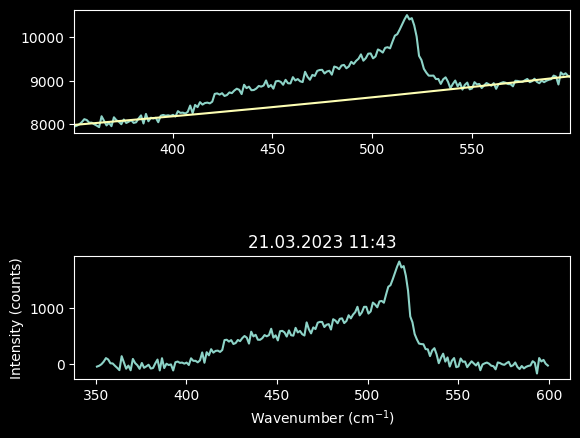

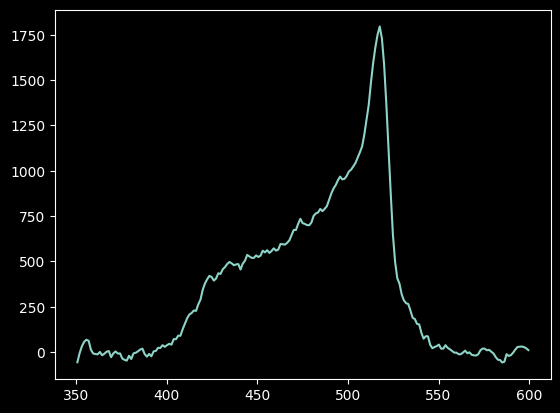

In [4]:
i = 2
sp0 = RamanSpectrum(files[i])
sp0.crop(lower=350, upper=600)
sp0.polifit(a=400, b = 550, ord = 2)
plt.plot(sp0.polylx, sp0.polyly)
sp0.sav_gol(10,2,sp0.polylx,sp0.polyly,show=False)
plt.plot(sp0.denoisedx, sp0.denoisedy)

Amplitudes: [ 592.34682844  950.51398958 1078.99034617]
Centers: [448.38516587 503.18529616 517.06106802]
Sigmas: [27.8585034  19.82940442  4.55581115]


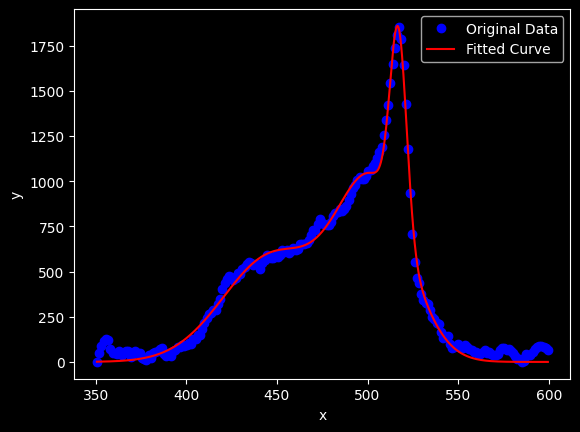

<Figure size 640x480 with 0 Axes>

In [5]:
sp0.get_fitting(x_=sp0.denoisedx, y_ = sp0.denoisedy, f2 = 0.9, f3 = 0.4 , c1 = 510, c2 = 440, c3 = 370, s1 = 30, s2 = 50, s3 = 50 ,show = True)

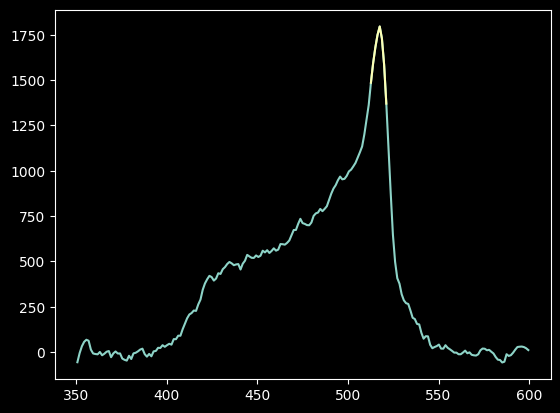

In [10]:
plt.plot(sp0.denoisedx, sp0.denoisedy)

nx = []
ny = []
for x,y in zip(sp0.denoisedx,sp0.denoisedy):
    if x < 522 and x > 512:
        nx.append(x)
        ny.append(y)

plt.plot(nx,ny) 

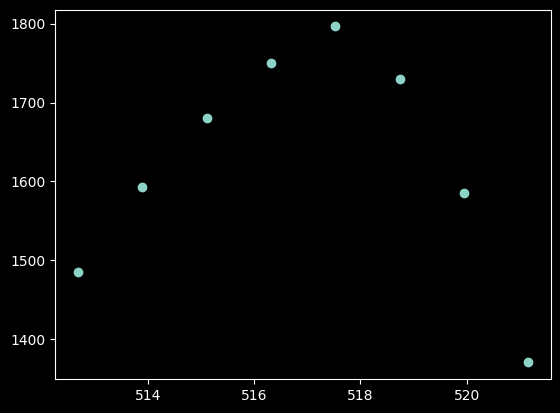

Bad pipe message: %s [b'DD\x0f[\xe3\x03\x07\x8f\xed\x14DC5\x06\xd2#\xcao \x1a`\x93\xc0\xfc\x06K\xd7\xa7\x85\x90\xdcS\x8a\x87\xafd(Q\x99\xc4K\xde}kb\xeb\xd6[\x96A\xd4\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$']
Bad pipe message: %s [b'\xa2\x0b\x1e\x9d_h\xf0:\xa8EQP;l\xbeuN3 \xcb\xc4]\xba\xf2\xc3,\xe85\xe5\xe6L\x84\xa1\xd1<\x84T\xb2\xe2MK\x0cn[\xea\x80\x99\xf2\x14\x86\xcb\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\

In [14]:
plt.plot(nx,ny,'o')

In [12]:
# We use gx and gy to fit this to a voigt profile
# Importing the wofz function from scipy.special

from scipy.special import wofz

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz(((x-cen) + 1j*gam)/sig/np.sqrt(2))) / sig / np.sqrt(2*np.pi)

# We need to define the initial guess for the parameters
center= 518
sigma = 30
gamma = -60
amplitude = 2000

# Now we can fit the data minimizing the difference between the actual data and the model using the curve_fit function from scipy.optimize

from scipy.optimize import curve_fit

# Using the initial parameters we defined above, we can fit the data

def plot_fit(xdata, ydata):
    popt, pcov = curve_fit(voigt, xdata, ydata, p0=[amplitude, center, sigma, gamma])

    # Plot the data and the fit
    plt.plot(xdata, ydata, 'b-', label='data')
    plt.plot(xdata, voigt(xdata, *popt), 'r-', label='fit')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    # Print the optimized parameters
    print('Optimized Amplitude = ', popt[0])
    print('Optimized Center = ', popt[1])
    print('Optimized Sigma = ', popt[2])
    print('Optimized Gamma = ', popt[3])
    plt.show()

plot_fit(nx, ny)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz
import ipywidgets as widgets
from IPython.display import display

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz(((x - cen) + 1j * gam) / sig / np.sqrt(2))) / sig / np.sqrt(2 * np.pi)

# Define the x-axis range
x = np.linspace(-100, 100, 10000)

# Create initial values for the parameters
initial_amp = 1.0
initial_cen = 0.0
initial_sig = 1.0
initial_gam = 1.0

# Create sliders for each parameter
amp_slider = widgets.FloatSlider(value=initial_amp, min=0.1, max=10.0, step=0.1, description='Amplitude:')
cen_slider = widgets.FloatSlider(value=initial_cen, min=-5.0, max=5.0, step=0.1, description='Center:')
sig_slider = widgets.FloatSlider(value=initial_sig, min=1.0, max=50.0, step=1.0, description='Sigma:')
gam_slider = widgets.FloatSlider(value=initial_gam, min=1.0, max=50.0, step=1.0, description='Gamma:')

# Define the update function
def update_plot(amp, cen, sig, gam):
    y = voigt(x, amp, cen, sig, gam)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Voigt Curve')
    plt.ylim(0, np.max(y) + 0.5)
    plt.show()

# Create the interactive plot
interactive_plot = widgets.interactive(update_plot, amp=amp_slider, cen=cen_slider, sig=sig_slider, gam=gam_slider)

# Display the interactive plot
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=10.0, min=0.1), FloatSlider(value=0…